In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io import wavfile
import librosa
import librosa.display
import numpy as np
from librosa.feature import rms
import noisereduce as nr


D:\projects\noisereduce\noisereduce\noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:

y, r = librosa.load('assets/LJSpeech_debabble/noisy/LJ001-0003_noisy_ip.wav')
ipd.Audio(data=y, rate=r)

In [3]:
    thresh = 0.5  # A window consistently
    hop_length = 256
    frame_length = 2048
    n_fft = 2048
    
    energy = rms(y=y, frame_length=frame_length, hop_length=hop_length)
    mean_energy = np.mean(energy)
    std_energy = np.std(energy)
    energy = energy[0]


In [4]:
energy.shape

(834,)

In [5]:
mean_energy, std_energy

(0.11085383, 0.06174326)

In [6]:
is_noise = energy < mean_energy - std_energy * thresh

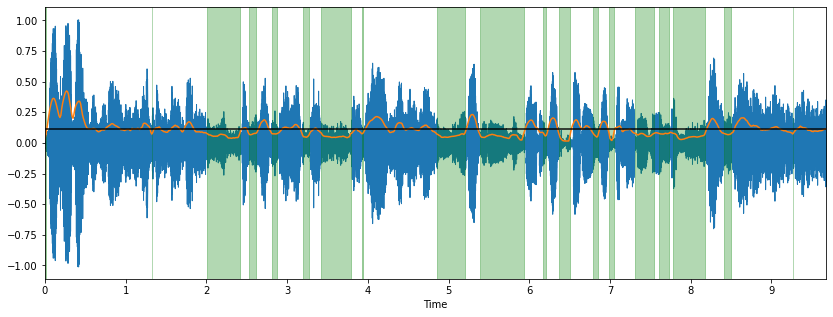

In [7]:
fig, ax = plt.subplots(figsize=(14, 5))

x = np.array(range(len(energy))) * hop_length / r
librosa.display.waveplot(y, sr=r)


ax.plot(x, energy)
ax.axhline(mean_energy, color='black', lw=2, alpha=0.7)
ax.fill_between(x, 0, 1, where=is_noise,color='green', alpha=0.3, transform=ax.get_xaxis_transform())


In [8]:
import itertools, operator

In [9]:
seqs = []
for k, v in itertools.groupby(enumerate(is_noise),operator.itemgetter(1)):
    seq = list(v)
    seq_start = seq[0][0] * hop_length
    seq_v = seq[0][1]
    seq_len = len(seq) * hop_length
    if seq_v:
        seqs.append({ 'start_samp': seq_start, 'start_t': round(seq_start / r,2), 'n_samps': seq_len, 'end_t': round((seq_start+seq_len) / r, 2),} )
  

In [10]:
seqs = sorted(seqs, key = lambda seq: seq['n_samps'], reverse=True)
seqs

[{'start_samp': 118784, 'start_t': 5.39, 'n_samps': 12288, 'end_t': 5.94},
 {'start_samp': 44288, 'start_t': 2.01, 'n_samps': 9216, 'end_t': 2.43},
 {'start_samp': 171520, 'start_t': 7.78, 'n_samps': 8960, 'end_t': 8.19},
 {'start_samp': 75520, 'start_t': 3.42, 'n_samps': 8448, 'end_t': 3.81},
 {'start_samp': 107008, 'start_t': 4.85, 'n_samps': 7936, 'end_t': 5.21},
 {'start_samp': 161280, 'start_t': 7.31, 'n_samps': 5376, 'end_t': 7.56},
 {'start_samp': 140544, 'start_t': 6.37, 'n_samps': 3072, 'end_t': 6.51},
 {'start_samp': 167680, 'start_t': 7.6, 'n_samps': 3072, 'end_t': 7.74},
 {'start_samp': 55808, 'start_t': 2.53, 'n_samps': 2048, 'end_t': 2.62},
 {'start_samp': 70400, 'start_t': 3.19, 'n_samps': 2048, 'end_t': 3.29},
 {'start_samp': 185600, 'start_t': 8.42, 'n_samps': 2048, 'end_t': 8.51},
 {'start_samp': 61952, 'start_t': 2.81, 'n_samps': 1792, 'end_t': 2.89},
 {'start_samp': 149760, 'start_t': 6.79, 'n_samps': 1536, 'end_t': 6.86},
 {'start_samp': 154112, 'start_t': 6.99, 'n

In [11]:
seq = seqs[0]  # Longest sequence of noise
noise = y[seq['start_samp']:seq['start_samp']+seq['n_samps']]
ipd.Audio(data=noise, rate=r)

In [12]:
reduced_noise = nr.reduce_noise(
        hop_length = hop_length,
        n_std_thresh=1.5,
        n_fft=frame_length,
        win_length=frame_length,
        audio_clip=y,
        noise_clip=noise,
        use_tensorflow=False,
        verbose=False)

In [13]:
ipd.Audio(data=reduced_noise, rate=r)

In [18]:
ipd.Audio(data=y, rate=r)

In [14]:
 import torch

In [15]:
torch.cuda.is_available()

True

In [16]:
torch.cuda.device_count()

1

In [17]:
noise_stft = librosa.stft(y=noise, n_fft=n_fft, hop_length=hop_length, win_length=frame_length, center=True)

In [ ]:
noise_stft_db = librosa.core.amplitude_to_db(noise_stft, ref=1.0, amin=1e-20, top_db=80.0)

In [ ]:
mean_freq_noise = np.mean(noise_stft_db, axis=1)
std_freq_noise = np.std(noise_stft_db, axis=1)
noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
